In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from uncertainties import ufloat
import uncertainties.unumpy as unumpy
import scipy.odr as ODR

Valores del circuito:

C = 220 nF 10% $\\$
R = 2700 $\Omega$ 5%

# Experimento 1

In [21]:
datos1 = pd.DataFrame(columns=['frec','errfrec', 'vi', 'vo', 'errvo','dt', 'errdt','nodo'])

In [3]:

# Función para agregar datos al DataFrame
def nuevo_dato(dataframe, datos):
    nuevo_df = pd.DataFrame([datos], columns=dataframe.columns)
    return pd.concat([dataframe, nuevo_df], ignore_index=True)

# Función para borrar datos del DataFrame
def borrar_dato(dataframe, indice):

    return dataframe.drop(index=indice).reset_index(drop=True)


## Agregando datos

Columnas de dataframe en orden y con unidades son: $\\$
'frec' (Hz), 'vi' (V), 'vo' (V), 'dt' (s), 'errvo' (V), 'nodo' 

In [73]:
datos1 = pd.DataFrame(columns=['frec','errfrec', 'vi', 'vo', 'errvo','dt', 'errdt','nodo'])
# Columnas del dataframe: 'frec', 'errfrec', 'vi', 'vo','errvo','dt','errdt','nodo'
datos1 = nuevo_dato(datos1, [1.6, 0.1 , 4.32, 3.72, 0.01, 38*10**(-3), 1*10**(-3), 5.0])
datos1 = nuevo_dato(datos1, [7.6, 0.1 , 13.4, 6.98, 0.02, 13*10**(-3), 1*10**(-3), 5.0])
datos1 = nuevo_dato(datos1, [13.7, 0.1 , 16.2, 6.98, 0.02, 9.5*10**(-3), 0.1*10**(-3), 5.0])
datos1 = nuevo_dato(datos1, [19.6, 0.1 , 17, 6.38, 0.02, 8*10**(-3), 0.1*10**(-3), 5.0])
datos1 = nuevo_dato(datos1, [40.3, 0.1 , 17.9, 4.48, 0.01, 5.5*10**(-3), 0.1*10**(-3), 5.0])
datos1 = nuevo_dato(datos1, [100, 1, 18.2, 1.99, 0.01, 3.44*10**(-3), 0.04*10**(-3), 5.0])
datos1 = nuevo_dato(datos1, [159, 1 , 18.1, 1.12, 0.01, 2.64*10**(-3), 0.02*10**(-3), 5.0])
# datos1 = nuevo_dato(datos1, [219, 1 , 18.2, 150*10**(-3), 2*10**(-3), 2.32*10**(-3), 0.02*10**(-3), 5.0]) #DATO IGNORADO POR MALA PRAXIS
datos1 = nuevo_dato(datos1, [222, 1 , 18.2, 638*10**(-3), 2*10**(-3), 2.18*10**(-3), 0.02*10**(-3), 5.0])
#datos1 = nuevo_dato(datos1, [306.5, 0.5 , 18.1, 1*10**(-3), 2*10**(-3), 2.32*10**(-3), 0.02*10**(-3), 5.0])
datos1 = nuevo_dato(datos1, [402, 1 , 18.1, 188*10**(-3), 2*10**(-3), 900*10**(-6), 10*10**(-6), 5.0])


C:\Users\nacho\AppData\Local\Temp\ipykernel_8256\1327993546.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([dataframe, nuevo_df], ignore_index=True)


In [ ]:
# Borrar todos los datos del dataframe (por si es necesario para reiniciar)
#datos1 = datos1.iloc[0:0]

In [23]:
datos1

,frec,errfrec,vi,vo,errvo,dt,errdt,nodo
0,1.6,0.1,4.32,3.72,0.01,0.0380,0.0010,5.0
1,7.6,0.1,13.40,6.98,0.02,0.0130,0.0010,5.0
2,13.7,0.1,16.20,6.98,0.02,0.0095,0.0001,5.0
3,19.6,0.1,17.00,6.38,0.02,0.0080,0.0001,5.0


## Defino nuevas columnas 

In [123]:
datos1['vo/vi'] = datos1['vo'] / datos1['vi']
datos1['errvi'] = 0.1
#datos1['err_vo/vi'] = calc_err(datos1['vi'], datos1['vo'], datos1['errvi'], datos1['errvo'])
datos1['fase'] = 2 * np.pi * datos1['frec'] * datos1['dt']

# Calculo err_vo/vi con ufloat
def calculate_err_vovi(row):
	if row['vi'] != 0:  # Que no divida por cero
		return (ufloat(row['vo'], row['errvo']) / ufloat(row['vi'], row['errvi'])).std_dev
	else:
		return np.nan

datos1['err_vo/vi'] = datos1.apply(calculate_err_vovi, axis=1)

def calculate_err_fase(row):
	if row['dt'] != 0:  # Que no divida por cero
		return round((2 * np.pi * row['frec'] * ufloat(row['dt'], row['errdt'])).std_dev, 2)
	else:
		return np.nan

datos1['errfase'] = datos1.apply(calculate_err_fase, axis=1)

def calculate_err_raiz(row):
	if row['frec'] != 0:  # Que no divida por cero
		return (ufloat(row['frec'], row['errfrec'])**(1/2)).std_dev
	else:
		return np.nan

datos1['errraiz'] = datos1.apply(calculate_err_raiz, axis=1)

In [ ]:
datos1

## Diagrama de Bode (Amplitud)

### Ajuste

In [128]:
x = datos1['frec']**(1/2)
y = datos1['vo/vi']
xerr = datos1['errraiz']
yerr = datos1['err_vo/vi']

def Ajuste(B, f):
  return np.exp(-B*f*5)

func = ODR.Model(Ajuste)
data_real = ODR.RealData(x, y, xerr, yerr)
odr = ODR.ODR(data_real, func,beta0=[1])
out = odr.run()

Aj = out.beta
Aj_err = out.sd_beta

out.pprint()
#tau=ufloat(Aj[0],Aj_err[0])
#print("Tau es", tau.nominal_value, "+-", tau.std_dev, "s")
#print(f"Tau = {tau:.5e} s")


Beta: [0.04486392]
Beta Std Error: [0.00028657]
Beta Covariance: [[5.08269323e-09]]
Residual Variance: 16.15723689220397
Inverse Condition #: 0.9999999999999999
Reason(s) for Halting:
  Sum of squares convergence


C:\Users\nacho\AppData\Local\Temp\ipykernel_8256\3647172470.py:7: RuntimeWarning: overflow encountered in exp
  return np.exp(-B*f*5)


### Ploteo

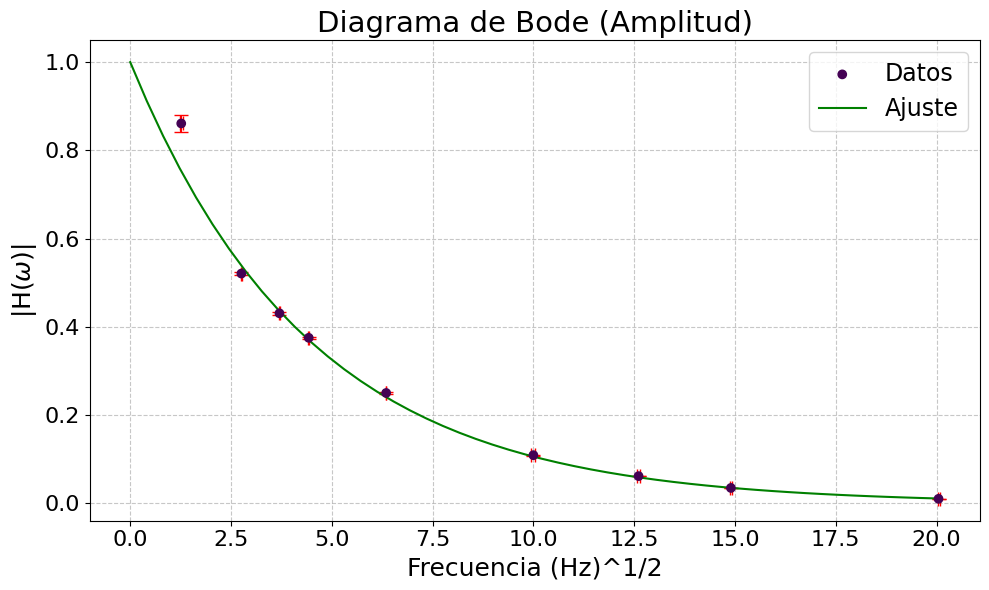

In [129]:
x = datos1['frec']**(1/2)
y = datos1['vo/vi']
xerr = datos1['errraiz']
yerr = datos1['err_vo/vi']

fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(x, y, c=datos1['nodo'], cmap='viridis', zorder=4, label="Datos")
ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt="none", ecolor="red", zorder=3, capsize=5)
ax.plot(np.linspace(0,20), Ajuste(Aj[0], np.linspace(0,20)), "-", color='green', zorder=3, label='Ajuste')
#plt.colorbar(scatter, ax=ax, label='Nodo')  # Agregar barra de color para referencia
#ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt="bo",
#            ecolor= "red", zorder=4, label="Datos",capsize=5)
#ax.plot(np.logspace(1, np.log10(2*(10**6))), Ajuste(Aj[0], np.logspace(1, np.log10(2*(10**6)))), "-", color='green', zorder=3, label='Ajuste')
#ax.plot(np.logspace(1, np.log10(2*(10**6))), Ajuste1(Aj1[0], np.logspace(1, np.log10(2*(10**6)))), "-", color='green', zorder=3, label='Ajuste Fase')

#ax.plot(np.logspace(1, np.log10(2*(10**6))), Ajuste(1e-4, np.logspace(1, np.log10(2*(10**6)))), "-", color='teal', label="Modelo")
#ax.set_xscale("log")
#ax.set_yscale("log")
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(fontsize=17)
plt.xticks(fontsize='16')
plt.yticks(fontsize='16')

ax.set_xlabel("Frecuencia (Hz)^1/2", fontsize=18)
ax.set_ylabel(r"|H($\omega$)|", fontsize=18) #Sería más correcto usar H(f), los datos son de frecuencia, no frecuencia angular
ax.set_title("Diagrama de Bode (Amplitud)", fontsize=21)

plt.tight_layout()
plt.show()

# Nodens

Frecuencia fija; cambiamos los nodos

In [118]:
datos2 = pd.DataFrame(columns=['frec','errfrec', 'vi', 'vo', 'errvo','dt', 'errdt','nodo'])
# Columnas del dataframe: 'frec', 'errfrec', 'vi', 'vo','errvo','dt','errdt','nodo'
datos2 = nuevo_dato(datos2, [25.08, 0.05 , 17.7, 14, 0.1, 1.4*10**(-3), 0.1*10**(-3), 1.0])
datos2 = nuevo_dato(datos2, [25.08, 0.05 , 17.7, 11.13, 0.1, 2.9*10**(-3), 0.1*10**(-3), 2.0])
datos2 = nuevo_dato(datos2, [25.08, 0.05 , 17.7, 9.16, 0.04, 4.3*10**(-3), 0.1*10**(-3), 3.0])
datos2 = nuevo_dato(datos2, [25.08, 0.05 , 17.7, 7.36, 0.01, 5.3*10**(-3), 0.1*10**(-3), 4.0])
datos2 = nuevo_dato(datos2, [25.08, 0.05 , 17.7, 5.92, 0.02, 6.6*10**(-3), 0.1*10**(-3), 5.0])
datos2 = nuevo_dato(datos2, [25.08, 0.05 , 17.7, 4.76, 0.04, 8.5*10**(-3), 0.1*10**(-3), 6.0])
datos2 = nuevo_dato(datos2, [25.08, 0.05 , 17.8, 3.74, 0.02, 9.6*10**(-3), 0.1*10**(-3), 7.0])
datos2 = nuevo_dato(datos2, [25.08, 0.05 , 17.8, 2.96, 0.02, 11*10**(-3), 0.1*10**(-3), 8.0])
datos2 = nuevo_dato(datos2, [25.08, 0.05 , 17.9, 2.38, 0.02, 12.6*10**(-3), 0.1*10**(-3), 9.0])
datos2 = nuevo_dato(datos2, [25.08, 0.05 , 17.8, 1.86, 0.02, 13.9*10**(-3), 0.1*10**(-3), 10.0])
datos2 = nuevo_dato(datos2, [25.08, 0.05 , 17.8, 1.48, 0.02, 15.4*10**(-3), 0.1*10**(-3), 11.0])
datos2 = nuevo_dato(datos2, [25.08, 0.05 , 17.9, 1.23, 0.01, 17.4*10**(-3), 0.1*10**(-3), 12.0])
datos2 = nuevo_dato(datos2, [25.08, 0.05 , 17.8, 1.08, 0.01, 19.5*10**(-3), 0.1*10**(-3), 13.0])
datos2 = nuevo_dato(datos2, [25.08, 0.05 , 17.8, 1, 0.02, 20.6*10**(-3), 0.2*10**(-3), 14.0])
datos2 = nuevo_dato(datos2, [25.08, 0.05 , 17.8, 0.94, 0.04, 21.5*10**(-3), 0.1*10**(-3), 15.0])
datos2 = nuevo_dato(datos2, [25.08, 0.05 , 17.8, 0.936, 0.02, 22.4*10**(-3), 0.2*10**(-3), 16.0])



datos2['vo/vi'] = datos2['vo'] / datos2['vi']
datos2['errvi'] = 0.1
datos2['fase'] = 2 * np.pi * datos2['frec'] * datos2['dt']

datos2['err_vo/vi'] = datos2.apply(calculate_err_vovi, axis=1)
datos2['errfase'] = datos2.apply(calculate_err_fase, axis=1)

C:\Users\nacho\AppData\Local\Temp\ipykernel_8256\1327993546.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([dataframe, nuevo_df], ignore_index=True)


C:\Users\nacho\AppData\Local\Temp\ipykernel_8256\1813777810.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, cmap='viridis', zorder=4, label="Datos")


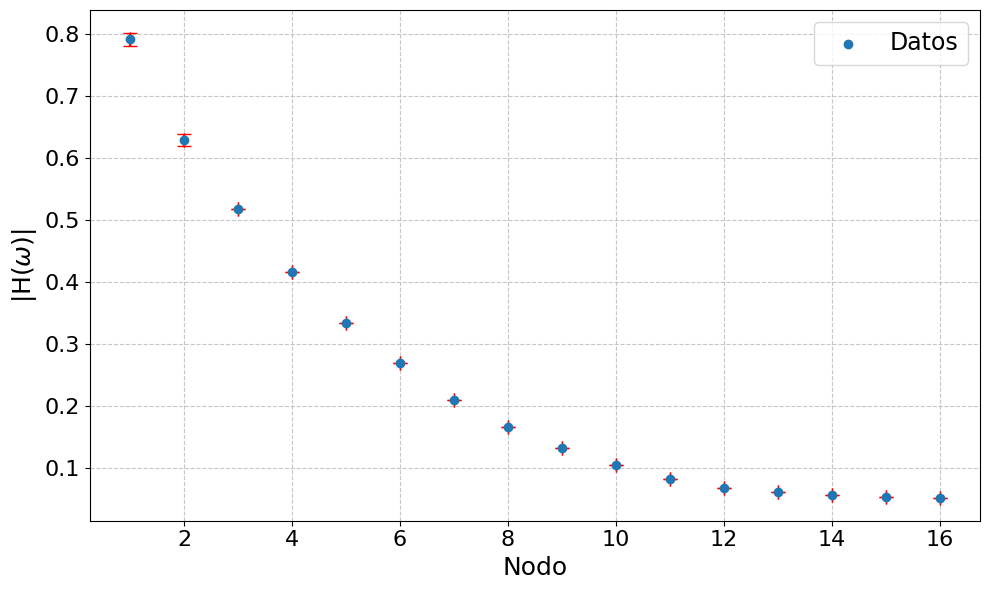

In [119]:
x = datos2['nodo']
y = datos2['vo/vi']
yerr = datos2['err_vo/vi']

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(x, y, cmap='viridis', zorder=4, label="Datos")
ax.errorbar(x, y, xerr=0, yerr=yerr, fmt="none", ecolor="red", zorder=3, capsize=5)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(fontsize=17)
plt.xticks(fontsize='16')
plt.yticks(fontsize='16')

ax.set_xlabel("Nodo", fontsize=18)
ax.set_ylabel(r"|H($\omega$)|", fontsize=18) 
#ax.set_title("Diagrama de Bode (Amplitud)", fontsize=21)

plt.tight_layout()
plt.show()

C:\Users\nacho\AppData\Local\Temp\ipykernel_8256\3809701253.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, cmap='viridis', zorder=4, label="Datos")


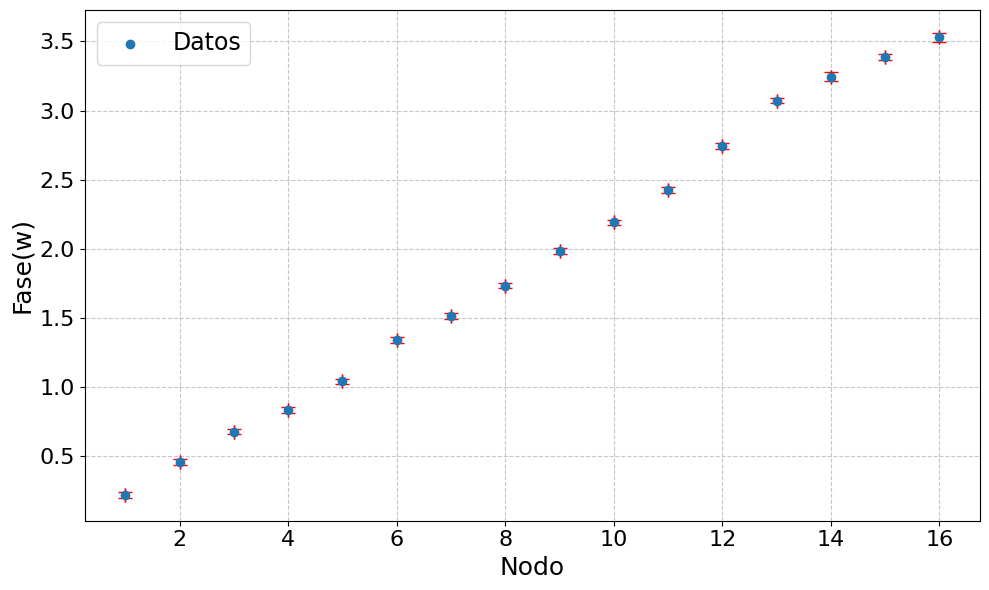

In [120]:
x = datos2['nodo']
y = datos2['fase']
yerr = datos2['errfase']

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(x, y, cmap='viridis', zorder=4, label="Datos")
ax.errorbar(x, y, xerr=0, yerr=yerr, fmt="none", ecolor="red", zorder=3, capsize=5)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(fontsize=17)
plt.xticks(fontsize='16')
plt.yticks(fontsize='16')

ax.set_xlabel("Nodo", fontsize=18)
ax.set_ylabel(r"Fase(w)", fontsize=18) 
#ax.set_title("Diagrama de Bode (Amplitud)", fontsize=21)

plt.tight_layout()
plt.show()

### Guardar csvs

In [121]:
datos1.to_csv('datos1.csv', index=False)
datos2.to_csv('datos2.csv', index=False)

## Diagrama de Bode (Fase)

### Ajuste

In [ ]:
x2 = datos1['frec']
y2 = datos1['fase']
xerr2 = datos1['frec'] * 0.05
yerr2 = datos1['fase'] * 0.05

In [ ]:
def Ajuste(B, f):
  return np.arctan(1/(B*2*np.pi*f))

func = ODR.Model(Ajuste)
data_real = ODR.RealData(x2, y2, xerr2, yerr2)
odr = ODR.ODR(data_real, func,beta0=[0.0001])
out = odr.run()

Aj = out.beta
Aj_err = out.sd_beta

tau=ufloat(Aj[0],Aj_err[0])
print("Tau es", Aj[0], "s")
print(f"Tau = {tau:.4e} s")

### Ploteo

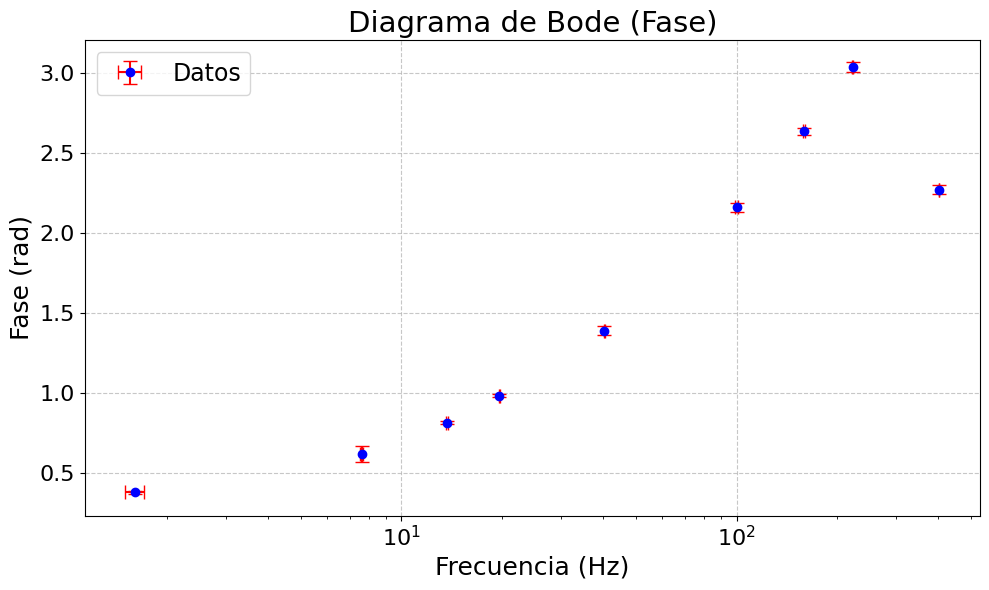

In [76]:
x2 = datos1['frec']
y2 = datos1['fase']
xerr2 = datos1['errfrec']
yerr2 = datos1['errfase']

fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(x2, y2, xerr = xerr2, yerr = yerr2, fmt="bo",
            ecolor= "red", zorder=4, label="Datos",capsize=5)
#ax.plot(np.logspace(1, np.log10(2*(10**6))), Ajuste(Aj[0], np.logspace(1, np.log10(2*(10**6)))), "-", color='green', zorder=3, label='Ajuste')
#ax.plot(np.logspace(1, np.log10(2*(10**6))), Ajuste(1e-4, np.logspace(1, np.log10(2*(10**6)))), "-", color='teal', label="Modelo")

ax.set_xscale("log")
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(fontsize=17)
plt.xticks(fontsize='16')
plt.yticks(fontsize='16')

ax.set_xlabel("Frecuencia (Hz)", fontsize=18)
ax.set_ylabel("Fase (rad)", fontsize=18)
ax.set_title("Diagrama de Bode (Fase)", fontsize=21)

plt.tight_layout()

## Diagrama de Nyquist

In [80]:
uy = unumpy.uarray(y, yerr)
uy2 = unumpy.uarray(y2, yerr2)

ReH = uy[1:] * unumpy.cos(uy2[1:])
ImH = uy[1:] * unumpy.sin(uy2[1:])

cen_ReH = unumpy.nominal_values(ReH)
cen_ImH = unumpy.nominal_values(ImH)

err_ReH = unumpy.std_devs(ReH)
err_ImH = unumpy.std_devs(ImH)

### Ploteo

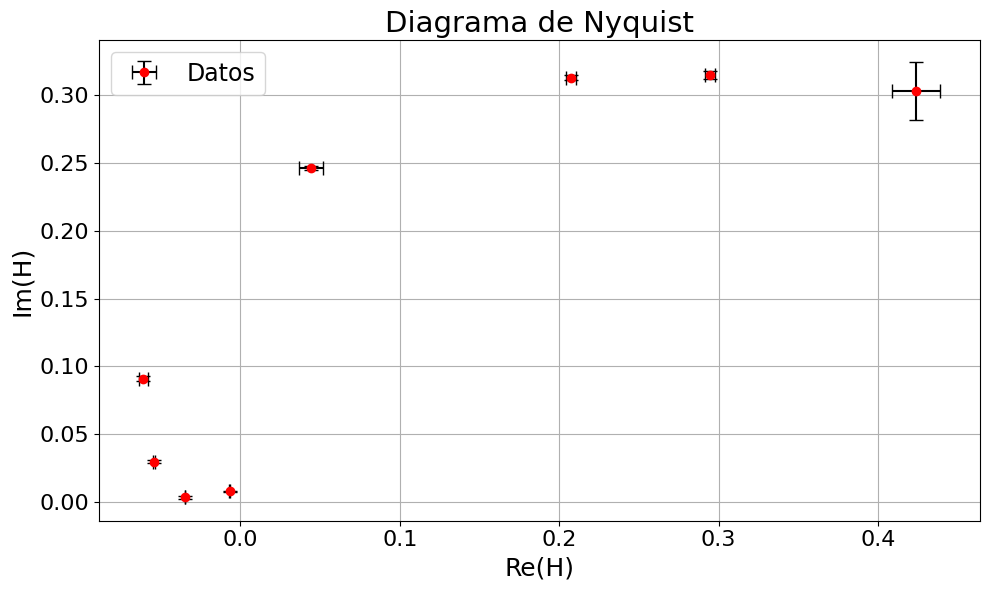

In [81]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(cen_ReH, cen_ImH, xerr= err_ReH, yerr= err_ImH, fmt="ro", label='Datos', ecolor ='black', capsize=5)

ax.set_xlabel("Re(H)", fontsize=18)
ax.set_ylabel('Im(H)', fontsize=18)
ax.set_title("Diagrama de Nyquist", fontsize=21)

ax.grid()
ax.legend(fontsize=17)
plt.xticks(fontsize='16')
plt.yticks(fontsize='16')

plt.tight_layout()
plt.show()